# **Enterprise Policy AI Chatbot: RAG-Powered QA System with LangChain Agents & LLM Optimization**


## **Overview**  
In this project, we will build an AI-powered assistant that can read and summarize private documents using **Retrieval-Augmented Generation (RAG)**, **LangChain**, and **LLMs**. This enables quick access to essential information without manually reading large volumes of text.

## **Steps to Build the Solution**  

### **1. Understanding RAG & LangChain**  
- **RAG (Retrieval-Augmented Generation)**: Enhances LLMs by incorporating external/private data for better responses.  
- **LangChain**: A framework for building applications that leverage LLMs with external data retrieval.

### **2. Setting Up the Environment**  
- Install required Python libraries: `langchain`, `faiss`, `openai`, etc.  
- Import necessary modules for document processing.

### **3. Preprocessing Documents**  
- **Load the document**: Use `DocumentLoaders` to read files.  
- **Split into chunks**: Break large text into manageable parts.  
- **Embed and store**: Convert text into embeddings and store in a vector database like **FAISS**.

### **4. Implementing the RAG Pipeline**  
- **Indexing**: Prepare and store documents for retrieval.  
- **Retrieval & Generation**:  
  - Retrieve relevant sections from the vector store based on user queries.  
  - Use an LLM to generate responses using retrieved information.

### **5. Enhancing with LangChain Features**  
- **Prompt Templates**: Structure inputs for better results.  
- **Memory**: Make conversations context-aware.  
- **Agent Integration**: Automate summarization with AI agents.


## **Key Takeaways**  
By the end of this project, you will have a fully functional **document summarization assistant** that allows you to efficiently extract insights from private files without exposing them to external AI services.


### RAG Architecture

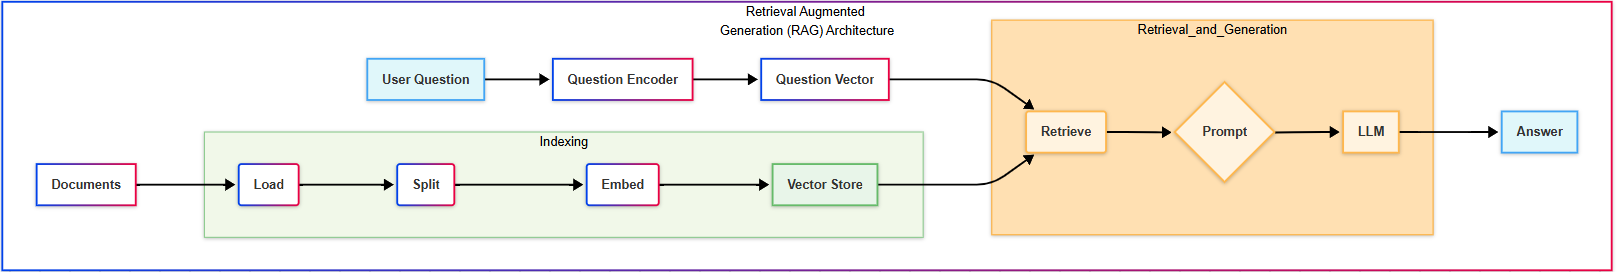

In [2]:
from IPython.display import Image

image_path = "RAG_Architecture.PNG"

Image(filename=image_path)

## Setup


In [ ]:
%%capture
!pip install --user "langchain==0.1.16"
!pip install --user "huggingface == 0.0.1"
!pip install --user "huggingface-hub == 0.23.4"

After the installation of libraries is completed, restart your kernel

### Importing required libraries

In [ ]:
%%capture
# 1. Clean previous installations
!pip uninstall -y torch torchvision torchaudio sentence-transformers transformers

# 2. Install CPU-only PyTorch + torchvision (compatible versions)
!pip install torch==2.1.0+cpu torchvision==0.16.0+cpu torchaudio==0.13.0 --index-url https://download.pytorch.org/whl/cpu

# 3. Install sentence-transformers (specific version that works with PyTorch 2.1.0)
!pip install sentence-transformers==2.5.1

# 4.  Ensure HuggingFace transformers is installed
!pip install transformers==4.40.0

In [ ]:
%%capture
# 1. Clean slate (ignore warnings)
!pip uninstall -y torch torchvision torchaudio sentence-transformers transformers timm fastai

# 2. Install CPU-only versions (critical: use --no-deps to prevent auto-upgrades)
!pip install --no-cache-dir --no-deps torch==2.1.0+cpu torchvision==0.16.0+cpu --index-url https://download.pytorch.org/whl/cpu

# 3. Install sentence-transformers with pinned dependencies
!pip install --no-cache-dir sentence-transformers==2.5.1 transformers==4.40.0

In [ ]:
%%capture
!pip install sentence-transformers
!pip install chromadb

In [61]:
%%capture
!pip install langchainhub

In [2]:
# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# from langchain.document_loaders import TextLoader
from langchain.document_loaders.text import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

## Preprocessing
### Load the document (Company policies)

In [3]:
filename = 'companyPolicies.txt'
with open(filename, 'r') as file:
    # Read the contents of the file
    contents = file.read()
    print(len(contents))

8019


### Splitting the document into chunks


In this step, we split the document into smaller parts, called chunks, using LangChain. This helps manage large documents efficiently.

Key Points:
- Chunking is part of the Indexing process.

- LangChain's CharacterTextSplitter is used to divide the document into smaller sections.

- Chunk size: Set to 1000 characters in this project.

- Default separator: \n\n (double newline).

- Custom separator: Can be changed using the separator parameter (e.g., separator="\n").

In [4]:
loader = TextLoader(filename)
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
print(len(texts))

11


### Embedding and storing
In this step, the text chunks are converted into numerical representations using a process called embedding. This helps the computer efficiently recognize and retrieve relevant information later.

The embedding process happens during Indexing, ensuring quick and accurate searches within the document. The following code creates an embedding model using Hugging Face and stores the embeddings in ChromaDB:

In [5]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

# Convert text documents to vectors
print("Converting text documents to vectors...")
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': False}  # Reduces memory usage
)

print("Storing vectors in ChromaDB and saving to ./chroma_db.")
docsearch = Chroma.from_documents(
    documents=texts,
    embedding=embeddings,  # Now explicitly bound to the DB
    persist_directory="./chroma_db"  # Allows reloading later
)

Converting text documents to vectors...
Storing vectors in ChromaDB and saving to ./chroma_db.


In [6]:
# Purpose: Reload existing ChromaDB for queries
# When to Run: After restarting your notebook/kernel
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

# Reinitialize embeddings (MUST match initial config)
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': False}
)

# Load existing ChromaDB
docsearch = Chroma(
    persist_directory="./chroma_db",  # Load from disk
    embedding_function=embeddings   # Required for queries
)

# Create retriever
retriever = docsearch.as_retriever()
print("✅ ChromaDB and retriever ready!")

✅ ChromaDB and retriever ready!


Up to this point, you've been performing the `Indexing` task. The next step is the `Retrieval` task.


###Retrieve (Fetching Relevant Documents)

The user’s question is encoded into a vector, which is then used to fetch the most relevant documents from the ChromaDB vector store.

In [7]:
retriever = docsearch.as_retriever(
    search_type="similarity",  # Default, good for policy QA
    search_kwargs={
        "k": 1  # Number of documents to retrieve
    }
)

query = "What is the mobile policy?"
retrieved_docs = retriever.get_relevant_documents(query)

print("\nTop Retrieved Documents:")
for i, doc in enumerate(retrieved_docs):
    print(f"{i+1}. {doc.page_content}")



Top Retrieved Documents:
1. Designated Areas: Smoking and vaping are permitted only in designated outdoor areas, clearly marked and located at least 25 feet from building entrances.
Prohibited Areas: Smoking is strictly prohibited in all indoor spaces, company vehicles, and near air intake vents.
Disposal: Cigarette butts and vaping waste must be properly disposed of in designated receptacles.
Consideration: Smokers must be mindful of non-smoking colleagues and avoid congregating near doorways or walkways.
Compliance: Violations may result in disciplinary action, including warnings or revocation of smoking privileges.

This policy promotes a respectful and healthy workplace for all employees.

Mobile Device Policy

Our Mobile Device Policy establishes guidelines for the appropriate use of personal and company-issued mobile devices in the workplace.


✅ This ensures that the retrieval process works before proceeding to LLM.

###Prompt (Structuring the Input for LLM)
The retrieved documents are formatted into a structured prompt that the LLM can use to generate an answer.

In [8]:
from langchain.prompts import PromptTemplate

policy_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""Analyze the following policy documents and provide a concise answer to the question.

Policy Documents:
{context}

Question: {question}

Answer in this format:
- Start with "According to company policy:" if relevant
- Provide a 1-2 sentence summary
- List key points as bullet items
- Highlight important numbers/dates like [25 feet]
- If no policy is found, say "This policy isn't covered in current documents"

Direct answer:"""
)

✅ Ensures the LLM receives structured and useful input.

###LLM (Generating the Final Answer)
We use a foundation model to process the prompt and generate a human-like response.

In [9]:
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# Load a small CPU-friendly model
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Create a local pipeline
llm_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=200,
    temperature=0.3,
    device="cpu"  # Force CPU usage
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

Device set to use cpu


###Chatbot with Memory
We'll use LangChain's ConversationBufferMemory. This will allow the bot to remember previous interactions in the current session.

In [59]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
import time

# Initialize components
embeddings = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2",
    model_kwargs={'device': 'cpu'}
)

docsearch = Chroma(
    persist_directory="./chroma_db",
    embedding_function=embeddings
)

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key='answer'
)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=docsearch.as_retriever(search_kwargs={"k": 2}),
    memory=memory,
    combine_docs_chain_kwargs={"prompt": policy_prompt},
    verbose=False
)

# Modified UI Elements with memory testing features
input_box = widgets.Text(placeholder='Ask about policies...', layout=widgets.Layout(width='80%'))
output_area = widgets.Output(layout=widgets.Layout(max_height='500px', overflow='auto'))
submit_btn = widgets.Button(description="Ask", button_style='primary')
memory_test_btn = widgets.Button(description="Test Memory", button_style='info')

def show_thinking():
    """Display thinking animation"""
    with output_area:
        clear_output()
        display(HTML("""
        <div style='text-align:center'>
            <div style='border:5px solid #f3f3f3; border-top:5px solid #3498db; border-radius:50%;
                      width:30px; height:30px; animation:spin 1s linear infinite; margin:10px auto;'></div>
            <p>Searching policies...</p>
        </div>
        <style>@keyframes spin {0%{transform:rotate(0deg);}100%{transform:rotate(360deg);}}</style>
        """))

def test_memory(b):
    """Explicitly test memory functionality"""
    with output_area:
        clear_output()
        if not memory.chat_memory.messages:
            print("🤖 No conversation history yet")
            return

        print("🧠 Memory Contents:")
        for i, msg in enumerate(memory.chat_memory.messages):
            prefix = "👤 Question" if i % 2 == 0 else "🤖 Answer"
            print(f"{prefix} {i//2 + 1}: {msg.content[:200]}{'...' if len(msg.content) > 200 else ''}")

def on_submit(b):
    question = input_box.value.strip()
    if not question:
        with output_area:
            print("⚠️ Please enter a question")
        return

    show_thinking()

    try:
        start_time = time.time()
        result = qa_chain({"question": question})
        response = result["answer"]

        if "Answer in this format:" in response:
            response = response.split("Direct answer:")[-1].strip()

        with output_area:
            clear_output()
            print(f"👤 You: {question}")
            print(f"🤖 Bot: {response}")
            print(f"\n⏱️ Response time: {time.time()-start_time:.1f} seconds")

            # Enhanced memory display
            print("\n--- Current Conversation Context ---")
            print(f"Total exchanges: {len(memory.chat_memory.messages)//2}")

            # Show last 2 exchanges with clear labels
            for i, msg in enumerate(memory.chat_memory.messages[-4:]):
                if i % 2 == 0:
                    print(f"\n🗣️ Q{i//2 + 1}: {msg.content[:100]}{'...' if len(msg.content) > 100 else ''}")
                else:
                    print(f"🤖 A{i//2 + 1}: {msg.content[:100]}{'...' if len(msg.content) > 100 else ''}")

    except Exception as e:
        with output_area:
            print(f"🚨 Error: {str(e)}")

    input_box.value = ""

# Display enhanced interface
display(widgets.VBox([
    widgets.Label("💼 Policy Assistant (Memory Test Mode)", style={'font_weight':'bold'}),
    input_box,
    widgets.HBox([submit_btn, memory_test_btn]),
    output_area
]))

submit_btn.on_click(on_submit)
memory_test_btn.on_click(test_memory)

###COMPANY POLICY QA AGENT

The following AI agent answers HR policy questions by searching company documents. It combines document retrieval with smart reasoning to provide accurate responses, while maintaining conversation history. The interface shows real-time status and prevents hallucinations by falling back to "Contact HR" when uncertain.

In [ ]:
from langchain.agents import Tool, AgentExecutor, initialize_agent
from langchain.chains import RetrievalQA
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

def policy_agent():
    # 1. Optimized Retrieval QA for TinyLlama
    qa_prompt = PromptTemplate(
        input_variables=["context", "question"],
        template="""Summarize this policy in 100 words or less:

        Policy Excerpt: {context}
        Question: {question}

        Answer MUST BE:
        - 2 to 3 sentences maximum

        - If unclear, respond "See HR handbook section [X.Y]"
        Answer:"""
    )

    qa = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=docsearch.as_retriever(
            search_kwargs={
                "k": 1,  # Only 1 document
                "score_threshold": 0.8  # High confidence matches only
            }
        ),
        chain_type_kwargs={
            "prompt": qa_prompt,
            "document_variable_name": "context"
        },
        verbose=False
    )

    # 2. Tools with TinyLlama-optimized limits
    def get_policy(query):
        try:
            result = qa.run(question=query[:50])  # Very short questions
            return result[:150]  # Hard token limit for TinyLlama
        except:
            return "Contact HR for policy details"

    tools = [
        Tool(
            name="HR_Policy_Lookup",
            func=get_policy,
            description="ONLY for verbatim policy quotes. Input must be under 50 characters."
        ),
        Tool(
            name="HR_Contact",
            func=lambda _: "Please contact HR at hr@company.com",
            description="Use when policy is not found or question is too complex"
        )
    ]

    # 3. Using CONVERSATIONAL_REACT_DESCRIPTION instead
    agent = initialize_agent(
        tools=tools,
        llm=llm,
        agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
        memory=ConversationBufferMemory(memory_key="chat_history"),
        verbose=False,
        max_execution_time=5,  # 5s timeout for CPU
        max_iterations=1,  # Only 1 reasoning step
        handle_parsing_errors="Please ask a shorter policy question (max 50 chars)"
    )

    print("HR Policy Assistant (TinyLlama CPU) ready. Ask short questions or 'quit':")
    while True:
        try:
            query = input("\nQuestion: ").strip()[:50]  # Hard input limit
            if query.lower() in ["quit", "exit"]:
                break

            response = agent.run(input=query)
            # Clean the output to remove agent thoughts if present
            if "Final Answer:" in response:
                response = response.split("Final Answer:")[-1].strip()
            print(f"Answer: {response[:150]}")  # Enforce output length

        except Exception as e:
            print("Please ask a simpler policy question or contact HR")

policy_agent()

HR Policy Assistant (TinyLlama CPU) ready. Ask short questions or 'quit':

Question: what is the smoking policy?
Answer: Sure, here's a general smoking policy that most companies have:

- Smoking is prohibited in all indoor areas, including offices, restaurants, and lobb
